# Util

In [ ]:
# @title Utils
test = False

from google.colab import drive

drive.mount("/content/drive")

path = "/content/drive/My Drive/Colab Notebooks/nonmyopic/"

try:
    import gpytorch
except:
    !pip install gpytorch
try:
    import botorch
except:
    !pip install botorch

import torch
import torch.optim as optim
from torch.optim import SGD
from tqdm import tqdm
import math
from math import exp
import itertools

import numpy as np

np.random.seed(1)

from matplotlib import cm
from matplotlib import pyplot as plt

import botorch
import gpytorch
from gpytorch.constraints import GreaterThan
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch import settings
from botorch.models import SingleTaskGP

color = {
    "C0": "#1f77b4",
    "C1": "#ff7f0e",
    "C2": "#2ca02c",
    "C3": "#d62728",
    "C4": "#9467bd",
    "C5": "#bcbd22",
    "C6": "#e377c2",
    "C7": "#17becf",
    # 'C8':'#bcbd22',
    # 'C9':'#17becf',
}

figsize = [7, 7]
plt.rcParams["figure.figsize"] = figsize

SMALL_SIZE = 14
MEDIUM_SIZE = 20
BIGGER_SIZE = 22


dpi = 100
imgtype = "png"

plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=16)  # fontsize of the tick labels
plt.rc("ytick", labelsize=16)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize


def ground_truth(
    draw_true_model=False, n_dim=1, draw_3D=False, alpha=1, ls=math.sqrt(0.05)
):
    if n_dim == 1:
        xs = np.linspace(0, 1, 1000)[:, None]
        mean = np.zeros(xs.shape[0])
        cov = kern_exp_quad_noard(xs, xs, alpha=alpha, ls=ls)

        np.random.seed(24)
        ys = sample_mvn(mean, cov, 1).squeeze()
        if draw_true_model:
            plt.plot(xs, ys, color="blue", alpha=0.1)
        return xs, ys

    elif n_dim == 2:
        grid = 20j
        xs = np.mgrid[0:1:grid, 0:1:grid].reshape(2, -1).T
        mean = np.zeros(xs.shape[0])
        cov = kern_exp_quad_noard(xs, xs, alpha=alpha, ls=ls)

        np.random.seed(5)
        ys = sample_mvn(mean, cov, 1).squeeze()

        if draw_true_model:
            xpts = np.linspace(0, 1, int(abs(grid)))
            ypts = np.linspace(0, 1, int(abs(grid)))
            X, Y = np.meshgrid(xpts, ypts)
            resol = int(abs(grid))
            Z = ys.reshape(resol, resol).T

            if draw_3D:
                fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
                cf = ax.plot_surface(
                    X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False
                )
                cbar = plt.colorbar(cf, fraction=0.046, pad=0.04)

            cf = plt.contourf(X, Y, Z, 40, cmap=cm.coolwarm, zorder=0)
            cbar = plt.colorbar(cf, fraction=0.046, pad=0.04)

            plt.show()

        return xs, ys

    else:
        raise


def p_loss(x):
    return torch.maximum(torch.abs(x - 0.5) - 0.5, torch.tensor([0]))


if test:
    j = 2
    n_dim = 2
    alpha = 1
    ls = math.sqrt(0.05)
    xs, ys = ground_truth(draw=True, n_dim=n_dim, alpha=alpha, ls=ls)
    plt.show()
    xs_new0 = xs[j, :][None, :]
    ys_new0, _ = gp_post(xs, ys, xs_new0, alpha=alpha, ls=ls)
    print("diff: ", ys_new0.item() - ys[j].item())

In [2]:
# @title SingleTaskGP

# #!/usr/bin/env python3
# # Copyright (c) Meta Platforms, Inc. and affiliates.
# #
# # This source code is licensed under the MIT license found in the
# # LICENSE file in the root directory of this source tree.

# r"""
# Gaussian Process Regression models based on GPyTorch models.

# These models are often a good starting point and are further documented in the
# tutorials.

# `SingleTaskGP`, `FixedNoiseGP`, and `HeteroskedasticSingleTaskGP` are all
# single-task exact GP models, differing in how they treat noise. They use
# relatively strong priors on the Kernel hyperparameters, which work best when
# covariates are normalized to the unit cube and outcomes are standardized (zero
# mean, unit variance).

# These models all work in batch mode (each batch having its own hyperparameters).
# When the training observations include multiple outputs, these models use
# batching to model outputs independently.

# These models all support multiple outputs. However, as single-task models,
# `SingleTaskGP`, `FixedNoiseGP`, and `HeteroskedasticSingleTaskGP` should be
# used only when the outputs are independent and all use the same training data.
# If outputs are independent and outputs have different training data, use the
# `ModelListGP`. When modeling correlations between outputs, use a multi-task
# model like `MultiTaskGP`.
# """

# from __future__ import annotations

# from typing import Any, List, Optional, Union

# import torch
# from botorch import settings
# from botorch.models.gpytorch import BatchedMultiOutputGPyTorchModel
# from botorch.models.transforms.input import InputTransform
# from botorch.models.transforms.outcome import Log, OutcomeTransform
# from botorch.models.utils import fantasize as fantasize_flag, validate_input_scaling
# from botorch.sampling.samplers import MCSampler
# from gpytorch.constraints.constraints import GreaterThan
# from gpytorch.distributions.multivariate_normal import MultivariateNormal
# from gpytorch.kernels.matern_kernel import MaternKernel
# from gpytorch.kernels.scale_kernel import ScaleKernel
# from gpytorch.kernels import RBFKernel
# from gpytorch.likelihoods.gaussian_likelihood import (
#     _GaussianLikelihoodBase,
#     FixedNoiseGaussianLikelihood,
#     GaussianLikelihood,
# )
# from gpytorch.likelihoods.likelihood import Likelihood
# from gpytorch.likelihoods.noise_models import HeteroskedasticNoise
# from gpytorch.means.constant_mean import ConstantMean
# from gpytorch.means.mean import Mean
# from gpytorch.mlls.noise_model_added_loss_term import NoiseModelAddedLossTerm
# from gpytorch.models.exact_gp import ExactGP
# from gpytorch.module import Module
# from gpytorch.priors.smoothed_box_prior import SmoothedBoxPrior
# from gpytorch.priors.torch_priors import GammaPrior
# from torch import Tensor


# MIN_INFERRED_NOISE_LEVEL = 1e-4


# class SingleTaskGP(BatchedMultiOutputGPyTorchModel, ExactGP):
#     r"""A single-task exact GP model.

#     A single-task exact GP using relatively strong priors on the Kernel
#     hyperparameters, which work best when covariates are normalized to the unit
#     cube and outcomes are standardized (zero mean, unit variance).

#     This model works in batch mode (each batch having its own hyperparameters).
#     When the training observations include multiple outputs, this model will use
#     batching to model outputs independently.

#     Use this model when you have independent output(s) and all outputs use the
#     same training data. If outputs are independent and outputs have different
#     training data, use the ModelListGP. When modeling correlations between
#     outputs, use the MultiTaskGP.

#     Example:
#         >>> train_X = torch.rand(20, 2)
#         >>> train_Y = torch.sin(train_X).sum(dim=1, keepdim=True)
#         >>> model = SingleTaskGP(train_X, train_Y)
#     """

#     def __init__(
#         self,
#         train_X: Tensor,
#         train_Y: Tensor,
#         likelihood: Optional[Likelihood] = None,
#         covar_module: Optional[Module] = None,
#         mean_module: Optional[Mean] = None,
#         outcome_transform: Optional[OutcomeTransform] = None,
#         input_transform: Optional[InputTransform] = None,
#     ) -> None:
#         r"""
#         Args:
#             train_X: A `batch_shape x n x d` tensor of training features.
#             train_Y: A `batch_shape x n x m` tensor of training observations.
#             likelihood: A likelihood. If omitted, use a standard
#                 GaussianLikelihood with inferred noise level.
#             covar_module: The module computing the covariance (Kernel) matrix.
#                 If omitted, use a `MaternKernel`.
#             mean_module: The mean function to be used. If omitted, use a
#                 `ConstantMean`.
#             outcome_transform: An outcome transform that is applied to the
#                 training data during instantiation and to the posterior during
#                 inference (that is, the `Posterior` obtained by calling
#                 `.posterior` on the model will be on the original scale).
#             input_transform: An input transform that is applied in the model's
#                 forward pass.
#         """
#         with torch.no_grad():
#             transformed_X = self.transform_inputs(
#                 X=train_X, input_transform=input_transform
#             )
#         if outcome_transform is not None:
#             train_Y, _ = outcome_transform(train_Y)
#         self._validate_tensor_args(X=transformed_X, Y=train_Y)
#         ignore_X_dims = getattr(self, "_ignore_X_dims_scaling_check", None)
#         validate_input_scaling(
#             train_X=transformed_X, train_Y=train_Y, ignore_X_dims=ignore_X_dims
#         )
#         self._set_dimensions(train_X=train_X, train_Y=train_Y)
#         train_X, train_Y, _ = self._transform_tensor_args(X=train_X, Y=train_Y)
#         if likelihood is None:
#             # noise_prior = GammaPrior(1.1, 0.05)
#             noise_prior = GammaPrior(concentration=0.5, rate=1)
#             noise_prior_mode = (noise_prior.concentration - 1) / noise_prior.rate
#             likelihood = GaussianLikelihood(
#                 noise_prior=noise_prior,
#                 batch_shape=self._aug_batch_shape,
#                 noise_constraint=GreaterThan(
#                     MIN_INFERRED_NOISE_LEVEL,
#                     transform=None,
#                     initial_value=noise_prior_mode,
#                 ),
#             )
#         else:
#             self._is_custom_likelihood = True
#         ExactGP.__init__(self, train_X, train_Y, likelihood)
#         if mean_module is None:
#             mean_module = ConstantMean(batch_shape=self._aug_batch_shape)
#         self.mean_module = mean_module
#         if covar_module is None:
#             covar_module = \
#                 ScaleKernel(
#                     # MaternKernel(
#                     #     nu=2.5,
#                     #     ard_num_dims=transformed_X.shape[-1],
#                     #     batch_shape=self._aug_batch_shape,
#                     #     lengthscale_prior=GammaPrior(3.0, 6.0),),
#                     RBFKernel(
#                         ard_num_dims=transformed_X.shape[-1],
#                         batch_shape=self._aug_batch_shape,
#                         lengthscale_prior=GammaPrior(3.0, 6.0),),
#                     batch_shape=self._aug_batch_shape,
#                     outputscale_prior=GammaPrior(2.0, 0.15),
#                 )
#             self._subset_batch_dict = {
#                 "likelihood.noise_covar.raw_noise": -2,
#                 "mean_module.raw_constant": -1,
#                 "covar_module.raw_outputscale": -1,
#                 "covar_module.base_kernel.raw_lengthscale": -3,
#             }
#         self.covar_module = covar_module
#         # TODO: Allow subsetting of other covar modules
#         if outcome_transform is not None:
#             self.outcome_transform = outcome_transform
#         if input_transform is not None:
#             self.input_transform = input_transform
#         self.to(train_X)

#     def forward(self, x: Tensor) -> MultivariateNormal:
#         if self.training:
#             x = self.transform_inputs(x)
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return MultivariateNormal(mean_x, covar_x)

In [3]:
# @title GP Util

"""
Utilities for Gaussian process (GP) inference.
"""

import numpy as np
from scipy.linalg import solve_triangular
from scipy.spatial.distance import cdist
import itertools


def kern_exp_quad_ard(xmat1, xmat2, ls, alpha):
    """
    Exponentiated quadratic kernel function with
    dimensionwise lengthscales if ls is an ndarray.
    """
    xmat1 = np.expand_dims(xmat1, axis=1)
    xmat2 = np.expand_dims(xmat2, axis=0)
    diff = xmat1 - xmat2
    diff /= ls
    norm = np.sum(diff**2, axis=-1) / 2.0
    kern = alpha**2 * np.exp(-norm)
    return kern


def kern_exp_quad_ard_sklearn(xmat1, xmat2, ls, alpha):
    """
    Exponentiated quadratic kernel function with dimensionwise lengthscales if ls is an
    ndarray, based on scikit-learn implementation.
    """
    dists = cdist(xmat1 / ls, xmat2 / ls, metric="sqeuclidean")
    exp_neg_norm = np.exp(-0.5 * dists)
    return alpha**2 * exp_neg_norm


def kern_exp_quad_ard_per(xmat1, xmat2, ls, alpha, pdims, period=2):
    """
    Exponentiated quadratic kernel function with
    - dimensionwise lengthscales if ls is an ndarray
    - periodic dimensions denoted by pdims. We assume that the period
    is 2.
    """
    xmat1 = np.expand_dims(xmat1, axis=1)
    xmat2 = np.expand_dims(xmat2, axis=0)
    diff = xmat1 - xmat2
    diff[..., pdims] = np.sin((np.pi * diff[..., pdims] / period) % (2 * np.pi))
    # diff[..., pdims] = np.cos( (np.pi/2) + (np.pi * diff[..., pdims] / period) )
    diff /= ls
    norm = np.sum(diff**2, axis=-1) / 2.0
    kern = alpha**2 * np.exp(-norm)

    return kern


def kern_exp_quad_noard(xmat1, xmat2, ls, alpha):
    """
    Exponentiated quadratic kernel function (aka squared exponential kernel aka
    RBF kernel).
    """
    kern = alpha**2 * kern_exp_quad_noard_noscale(xmat1, xmat2, ls)
    return kern


def kern_exp_quad_noard_noscale(xmat1, xmat2, ls):
    """
    Exponentiated quadratic kernel function (aka squared exponential kernel aka
    RBF kernel), without scale parameter.
    """
    distmat = squared_euc_distmat(xmat1, xmat2)
    norm = distmat / (2 * ls**2)
    exp_neg_norm = np.exp(-norm)
    return exp_neg_norm


def squared_euc_distmat(xmat1, xmat2, coef=1.0):
    """
    Distance matrix of squared euclidean distance (multiplied by coef) between
    points in xmat1 and xmat2.
    """
    return coef * cdist(xmat1, xmat2, "sqeuclidean")


def kern_distmat(xmat1, xmat2, ls, alpha, distfn):
    """
    Kernel for a given distmat, via passed in distfn (which is assumed to be fn
    of xmat1 and xmat2 only).
    """
    distmat = distfn(xmat1, xmat2)
    kernmat = alpha**2 * np.exp(-distmat / (2 * ls**2))
    return kernmat


def kern_simple_list(xlist1, xlist2, ls, alpha, base_dist=5.0):
    """
    Kernel for two lists containing elements that can be compared for equality.
    K(a,b) = 1 + base_dist if a and b are equal and K(a,b) = base_dist otherwise.
    """
    distmat = simple_list_distmat(xlist1, xlist2)
    distmat = distmat + base_dist
    kernmat = alpha**2 * np.exp(-distmat / (2 * ls**2))
    return kernmat


def simple_list_distmat(xlist1, xlist2, weight=1.0, additive=False):
    """
    Return distance matrix containing zeros when xlist1[i] == xlist2[j] and 0 otherwise.
    """
    prod_list = list(itertools.product(xlist1, xlist2))
    len1 = len(xlist1)
    len2 = len(xlist2)
    try:
        binary_mat = np.array([x[0] != x[1] for x in prod_list]).astype(int)
    except:
        # For cases where comparison returns iterable of bools
        binary_mat = np.array([all(x[0] != x[1]) for x in prod_list]).astype(int)

    binary_mat = binary_mat.reshape(len1, len2)

    if additive:
        distmat = weight + binary_mat
    else:
        distmat = weight * binary_mat

    return distmat


def get_product_kernel(kernel_list, additive=False):
    """Given a list of kernel functions, return product kernel."""

    def product_kernel(x1, x2, ls, alpha):
        """Kernel returning elementwise-product of kernel matrices from kernel_list."""
        mat_prod = kernel_list[0](x1, x2, ls, 1.0)
        for kernel in kernel_list[1:]:
            if additive:
                mat_prod = mat_prod + kernel(x1, x2, ls, 1.0)
            else:
                mat_prod = mat_prod * kernel(x1, x2, ls, 1.0)
        mat_prod = alpha**2 * mat_prod
        return mat_prod

    return product_kernel


def get_cholesky_decomp(k11_nonoise, sigma, psd_str):
    """Return cholesky decomposition."""
    if psd_str == "try_first":
        k11 = k11_nonoise + sigma**2 * np.eye(k11_nonoise.shape[0])
        try:
            return stable_cholesky(k11, False)
        except np.linalg.linalg.LinAlgError:
            return get_cholesky_decomp(k11_nonoise, sigma, "project_first")
    elif psd_str == "project_first":
        k11_nonoise = project_symmetric_to_psd_cone(k11_nonoise)
        return get_cholesky_decomp(k11_nonoise, sigma, "is_psd")
    elif psd_str == "is_psd":
        k11 = k11_nonoise + sigma**2 * np.eye(k11_nonoise.shape[0])
        return stable_cholesky(k11)


def stable_cholesky(mmat, make_psd=True, verbose=False):
    """Return a 'stable' cholesky decomposition of mmat."""
    if mmat.size == 0:
        return mmat
    try:
        lmat = np.linalg.cholesky(mmat)
    except np.linalg.linalg.LinAlgError as e:
        if not make_psd:
            raise e
        diag_noise_power = -11
        max_mmat = np.diag(mmat).max()
        diag_noise = np.diag(mmat).max() * 1e-11
        break_loop = False
        while not break_loop:
            try:
                lmat = np.linalg.cholesky(
                    mmat + ((10**diag_noise_power) * max_mmat) * np.eye(mmat.shape[0])
                )
                break_loop = True
            except np.linalg.linalg.LinAlgError:
                if diag_noise_power > -9:
                    if verbose:
                        print(
                            "\t*stable_cholesky failed with "
                            "diag_noise_power=%d." % (diag_noise_power)
                        )
                diag_noise_power += 1
            if diag_noise_power >= 5:
                print("\t*stable_cholesky failed: added diag noise = %e" % (diag_noise))
    return lmat


def project_symmetric_to_psd_cone(mmat, is_symmetric=True, epsilon=0):
    """Project symmetric matrix mmat to the PSD cone."""
    if is_symmetric:
        try:
            eigvals, eigvecs = np.linalg.eigh(mmat)
        except np.linalg.LinAlgError:
            print("\tLinAlgError encountered with np.eigh. Defaulting to eig.")
            eigvals, eigvecs = np.linalg.eig(mmat)
            eigvals = np.real(eigvals)
            eigvecs = np.real(eigvecs)
    else:
        eigvals, eigvecs = np.linalg.eig(mmat)
    clipped_eigvals = np.clip(eigvals, epsilon, np.inf)
    return (eigvecs * clipped_eigvals).dot(eigvecs.T)


def solve_lower_triangular(amat, b):
    """Solves amat*x=b when amat is lower triangular."""
    return solve_triangular_base(amat, b, lower=True)


def solve_upper_triangular(amat, b):
    """Solves amat*x=b when amat is upper triangular."""
    return solve_triangular_base(amat, b, lower=False)


def solve_triangular_base(amat, b, lower):
    """Solves amat*x=b when amat is a triangular matrix."""
    if amat.size == 0 and b.shape[0] == 0:
        return np.zeros((b.shape))
    else:
        return solve_triangular(amat, b, lower=lower)


def sample_mvn(mu, covmat, nsamp):
    """
    Sample from multivariate normal distribution with mean mu and covariance
    matrix covmat.
    """
    mu = mu.reshape(-1)
    ndim = len(mu)
    lmat = stable_cholesky(covmat)
    umat = np.random.normal(size=(ndim, nsamp))
    return lmat.dot(umat).T + mu


def gp_post(x_train, y_train, x_pred, ls, alpha, full_cov=True):
    """Compute parameters of GP posterior"""
    k11_nonoise = kern_exp_quad_noard(x_train, x_train, alpha=alpha, ls=ls)
    lmat = get_cholesky_decomp(k11_nonoise, 1e-2, "try_first")
    smat = solve_upper_triangular(lmat.T, solve_lower_triangular(lmat, y_train))
    k21 = kern_exp_quad_noard(x_pred, x_train, alpha=alpha, ls=ls)
    mu2 = k21.dot(smat)
    k22 = kern_exp_quad_noard(x_pred, x_pred, alpha=alpha, ls=ls)
    vmat = solve_lower_triangular(lmat, k21.T)
    k2 = k22 - vmat.T.dot(vmat)
    if full_cov is False:
        k2 = np.sqrt(np.diag(k2))
    return mu2, k2


# def query(x):
#     assert len(x.shape) == 2

#     xs, ys = ground_truth(n_dim=x.shape[1])
#     xs_new = np.concatenate([xs, x], axis=0)

#     print('xs: ', xs.shape)
#     print('xs_new: ', xs_new.shape)

#     mean_new = np.zeros(xs_new.shape[0])
#     gram_new = np.array(cov_matrix(xs_new))

#     if x.shape[1] == 1: np.random.seed(62)
#     elif x.shape[1] == 2: np.random.seed(14)

#     ys_new = sample_mvn(mean_new, gram_new, 1).squeeze()

#     return ys_new[-x.shape[0]:]

# # We will use the simplest form of GP model, exact inference
# class ExactGPModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# def rbf_kernel(x1, x2, variance = 0.05):
#     return exp(-1 * (((x1-x2)**2).sum()) / (2*variance))

# def cov_matrix(xs):
#     return [[rbf_kernel(x1,x2) for x2 in xs] for x1 in xs]

In [4]:
# @title ModelInit


def func(train_x):
    alpha = 1
    ls = math.sqrt(0.05)

    xs, ys = ground_truth(draw_true_model=False, n_dim=n_dim, alpha=alpha, ls=ls)

    train_y, _ = gp_post(x_train=xs, y_train=ys, x_pred=train_x, alpha=alpha, ls=ls)

    train_y = torch.tensor(train_y, dtype=torch.float64)

    return train_y


def init_data(n_init=4):
    if n_dim == 1:
        train_x = np.linspace(0, 1, n_init).reshape(-1, n_dim)
    elif n_dim == 2:
        n_init = complex(0, n_init)
        train_x = np.mgrid[0:1:n_init, 0:1:n_init].reshape(2, -1).T
    else:
        raise

    train_x = np.concatenate([train_x, prev_x.reshape(-1, n_dim)], axis=0)
    train_y = func(train_x)

    train_x = torch.tensor(train_x, dtype=torch.float64)
    train_y = torch.tensor(train_y, dtype=torch.float64)

    return train_x, train_y


def init_model(n_dim, prev_x, train_x, train_y, train=False):
    train_y = train_y[:, None]
    model = SingleTaskGP(train_X=train_x, train_Y=train_y)
    if train:
        model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-6))

    mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
    mll = mll.to(train_x)

    if not train:
        alpha = 1
        ls = math.sqrt(0.05)
        model.covar_module.base_kernel.lengthscale = ls
        model.covar_module.outputscale = alpha
        model.likelihood.noise = 1e-10
    else:
        optimizer = SGD([{"params": model.parameters()}], lr=0.05)
        NUM_EPOCHS = 20000

        model.train()

        for epoch in range(NUM_EPOCHS):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, model.train_targets)
            loss.backward()
            if (epoch + 1) % 2000 == 0:
                print(
                    f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>2.2} ",
                    "lengthscale: ",
                    model.covar_module.base_kernel.lengthscale.data,
                    f"outputscale: {model.covar_module.outputscale.item():>2.2f} ",
                    f"noise: {model.likelihood.noise.item():>2.5f}",
                )

            optimizer.step()

    model.eval()

    return model


def draw_posterior(n_dim, model):
    if n_dim == 1:
        test_x = torch.linspace(0, 1, 100)
        posterior = model.posterior(test_x)
        test_y = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        plt.plot(
            test_x.cpu().detach().numpy(),
            test_y.cpu().detach().numpy(),
            "blue",
            label="Posterior mean",
        )
        plt.fill_between(
            test_x.cpu().detach().numpy(),
            lower.cpu().detach().numpy(),
            upper.cpu().detach().numpy(),
            alpha=0.25,
        )

    elif n_dim == 2:
        grid = 20j
        test_x = np.mgrid[0:1:grid, 0:1:grid].reshape(2, -1).T
        test_x = torch.tensor(test_x)

        posterior = model.posterior(test_x)
        test_y = posterior.mean.detach().numpy()

        xpts = np.linspace(0, 1, int(abs(grid)))
        ypts = np.linspace(0, 1, int(abs(grid)))
        X, Y = np.meshgrid(xpts, ypts)
        resol = int(abs(grid))
        Z = test_y.reshape(resol, resol).T

        cf = plt.contourf(X, Y, Z, 40, cmap=cm.coolwarm, zorder=0)
        cbar = plt.colorbar(cf, fraction=0.046, pad=0.04)

        plt.scatter(train_x[:, 0], train_x[:, 1], marker="*", color="black")

    else:
        raise

In [5]:
# @title EHIG


def compute_ehig(xi, horizon, neighbor_size):
    with settings.propagate_grads(state=True):
        for h in range(0, horizon + 1):
            pvs_x = xi[h - 1] if h > 0 else prev_x
            xi[h] = torch.sigmoid(xi[h]) * (neighbor_size * 2) + (pvs_x - neighbor_size)

        ehigs = 0
        sample_yi_on_xi_Di = {}
        prev_ind = np.ones(horizon) * -1
        p_f_on_Di = {}
        p_f_on_Di[0] = model
        sampler = SobolQMCNormalSampler(
            num_samples=4, resample=False, collapse_batch_dims=True, seed=0
        )

        p_y0_on_x0_D0 = model.posterior(xi[0])
        sample_yi_on_xi_Di[0] = sampler(p_y0_on_x0_D0)

        for ind in itertools.product(
            range(4),
            range(3),
            range(2),
        ):
            ind = ind + tuple([0] * (horizon - len(ind)))
            equal_bool = np.equal(ind, prev_ind)
            # finding the first false
            comp_ind = np.argmin(equal_bool)
            prev_ind = ind

            for i in range(horizon):
                if i >= comp_ind:
                    p_f_on_Di[i + 1] = p_f_on_Di[i].condition_on_observations(
                        xi[i], sample_yi_on_xi_Di[i][ind[i]]  # [ind[:i]],
                    )
                    sample_yi_on_xi_Di[i + 1] = sampler(
                        p_f_on_Di[i + 1].posterior(xi[i + 1])
                    )  # [ind[:i+1]]))

            ehig = sample_yi_on_xi_Di[horizon].mean()
            ehigs = ehigs + ehig

        ehig = ehigs / (4 * 3 * 2)

        return xi, ehig.squeeze()


def argmax_ehig(
    model,
    prev_x,
    horizon=10,
    ehig_opt_epoch=100,
    ehig_opt_lr=0.1,
    neighbor_size=0.1,
    use_lr_schedule=False,
):
    xi = []
    for h in range(horizon + 1):
        xi.append((torch.rand(dim_xi)).requires_grad_(True))

    optimizer = optim.Adam(xi, lr=ehig_opt_lr)
    if use_lr_schedule:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=10, eta_min=0.0001
        )

    result = []
    metric = []
    for epoch in tqdm(range(ehig_opt_epoch)):
        optimizer.zero_grad()
        xi_in = [element_xi.clone() for element_xi in xi]
        xi_out, ehig = compute_ehig(xi_in, horizon=horizon, neighbor_size=neighbor_size)
        ehig.backward(retain_graph=True)
        optimizer.step()
        if use_lr_schedule:
            scheduler.step()
        result.append([xi_out[i].detach() for i in range(horizon + 1)])
        metric.append(ehig.clone().detach())
        if epoch % 10 == 0:
            print(
                "x0: ",
                xi_out[0].data.tolist(),
                ", a: ",
                xi_out[-1].tolist(),
                ", loss: ",
                ehig.item(),
            )

    metric = torch.tensor(metric)
    best = torch.argmin(metric, dim=0).item()
    best_result = result[best]

    return best_result

In [ ]:
# @title 1D

save = True
n_dim = 1
dim_xi = [n_dim]
prev_x = torch.tensor([0.3])
neighbor_size = 0.1
budget = 10

horizon = 10
ehig_opt_epoch = 100
ehig_opt_lr = 0.1
use_lr_schedule = False
train = False

train_x, train_y = init_data(n_init=5)

for step in range(budget):
    model = init_model(
        n_dim=n_dim, prev_x=prev_x, train_x=train_x, train_y=train_y, train=train
    )

    best_result = argmax_ehig(
        model,
        prev_x,
        horizon=horizon,
        ehig_opt_epoch=ehig_opt_epoch,
        ehig_opt_lr=ehig_opt_lr,
        neighbor_size=neighbor_size,
        use_lr_schedule=use_lr_schedule,
    )

    next_x = best_result[0]
    next_y = func(next_x.reshape(-1, n_dim))

    train_x = torch.cat([train_x, next_x.reshape(-1, n_dim)])
    train_y = torch.cat([train_y, next_y])

    prev_x = next_x

    # plot
    if n_dim == 1:
        ground_truth(draw_true_model=True, n_dim=n_dim)

    plt.title(f"Step {step}")

    draw_posterior(n_dim=n_dim, model=model)
    plt.plot(train_x.squeeze().cpu().numpy(), train_y.squeeze().cpu().numpy(), "k*")

    plt.vlines(prev_x, -1, 1, color="black", label="Current location")
    plt.vlines(prev_x - neighbor_size, -1, 1, color="black", linestyle="--")
    plt.vlines(prev_x + neighbor_size, -1, 1, color="black", linestyle="--")

    plt.vlines(best_result[0], -1, 1, color="red", label="Optimal query")
    plt.vlines(best_result[-1], -1, 1, color="green", label="Optimal action")

    plt.tight_layout()
    plt.ylim(-1, 1)
    plt.legend()

    if save:
        plt.savefig(f"{path}/1D/step{step}.{imgtype}", dpi=dpi, bbox_inches="tight")

    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1%|          | 1/100 [00:07<12:02,  7.30s/it]

x0:  [[0.40055835247039795, 0.407879114151001]] , a:  [[0.48816588521003723, 0.4863460659980774]] , loss:  1.128394366504298


 11%|█         | 11/100 [01:20<10:43,  7.23s/it]

x0:  [[0.4097195267677307, 0.41410529613494873]] , a:  [[0.6539769172668457, 0.6476415991783142]] , loss:  -0.8598436584589226


 21%|██        | 21/100 [02:34<10:01,  7.61s/it]

x0:  [[0.41504448652267456, 0.41675835847854614]] , a:  [[0.7400994896888733, 0.7252776026725769]] , loss:  -1.4580394808390853


 31%|███       | 31/100 [03:55<09:19,  8.11s/it]

x0:  [[0.416814923286438, 0.4168952703475952]] , a:  [[0.7678220272064209, 0.7245562672615051]] , loss:  -1.5032934211761775


 41%|████      | 41/100 [05:08<07:16,  7.40s/it]

x0:  [[0.41742703318595886, 0.41601672768592834]] , a:  [[0.7774454355239868, 0.6848782300949097]] , loss:  -1.5819816364505705


 51%|█████     | 51/100 [06:24<06:12,  7.60s/it]

x0:  [[0.41772302985191345, 0.41542237997055054]] , a:  [[0.7820664644241333, 0.6525265574455261]] , loss:  -1.5859299254727908


 61%|██████    | 61/100 [07:37<04:47,  7.38s/it]

x0:  [[0.4179331660270691, 0.4158462882041931]] , a:  [[0.785252034664154, 0.6641665101051331]] , loss:  -1.5978203230711256


 71%|███████   | 71/100 [08:49<03:31,  7.29s/it]

x0:  [[0.41808515787124634, 0.41616442799568176]] , a:  [[0.7874274849891663, 0.6728113293647766]] , loss:  -1.6006772052850968


 81%|████████  | 81/100 [10:04<02:20,  7.40s/it]

x0:  [[0.41819998621940613, 0.416113942861557]] , a:  [[0.7889363765716553, 0.6657547950744629]] , loss:  -1.6042315835836922


 91%|█████████ | 91/100 [11:19<01:07,  7.45s/it]

x0:  [[0.418306440114975, 0.4160692095756531]] , a:  [[0.7902541756629944, 0.6625873446464539]] , loss:  -1.605837617415978


100%|██████████| 100/100 [12:26<00:00,  7.47s/it]


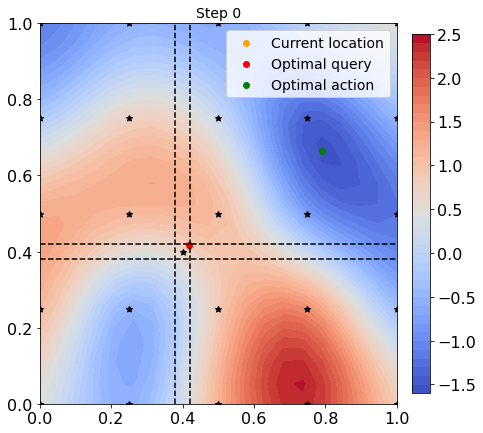

  1%|          | 1/100 [00:07<11:59,  7.27s/it]

x0:  [[0.42319637537002563, 0.42196792364120483]] , a:  [[0.5104645490646362, 0.5238789319992065]] , loss:  0.9837043305209671


 11%|█         | 11/100 [01:21<11:08,  7.52s/it]

x0:  [[0.4310230314731598, 0.42917385697364807]] , a:  [[0.6767989993095398, 0.6806745529174805]] , loss:  -1.1382303570564891


 21%|██        | 21/100 [02:39<10:03,  7.64s/it]

x0:  [[0.4348454773426056, 0.4316850006580353]] , a:  [[0.7564386129379272, 0.735858678817749]] , loss:  -1.4578581648948392


 31%|███       | 31/100 [03:55<08:51,  7.70s/it]

x0:  [[0.43597400188446045, 0.43169379234313965]] , a:  [[0.7809099555015564, 0.7201966643333435]] , loss:  -1.5234142907529062


 41%|████      | 41/100 [05:10<07:33,  7.68s/it]

x0:  [[0.4363076984882355, 0.4310479462146759]] , a:  [[0.7889723777770996, 0.6712893843650818]] , loss:  -1.6046013826553935


 51%|█████     | 51/100 [06:24<06:03,  7.41s/it]

x0:  [[0.43644264340400696, 0.43111735582351685]] , a:  [[0.793017566204071, 0.6426412463188171]] , loss:  -1.6031868557680353


 61%|██████    | 61/100 [07:36<04:41,  7.21s/it]

x0:  [[0.43655234575271606, 0.4318392872810364]] , a:  [[0.7961870431900024, 0.6564244627952576]] , loss:  -1.61700644898739


 71%|███████   | 71/100 [08:51<03:32,  7.33s/it]

x0:  [[0.4366515278816223, 0.43224215507507324]] , a:  [[0.7982515692710876, 0.6646691560745239]] , loss:  -1.619381492880928


 81%|████████  | 81/100 [10:03<02:15,  7.12s/it]

x0:  [[0.43674832582473755, 0.43227630853652954]] , a:  [[0.7994887828826904, 0.6579253077507019]] , loss:  -1.62214357118534


 91%|█████████ | 91/100 [11:17<01:06,  7.41s/it]

x0:  [[0.43685948848724365, 0.4322058856487274]] , a:  [[0.8005781173706055, 0.6543596982955933]] , loss:  -1.6230163591447855


100%|██████████| 100/100 [12:22<00:00,  7.42s/it]


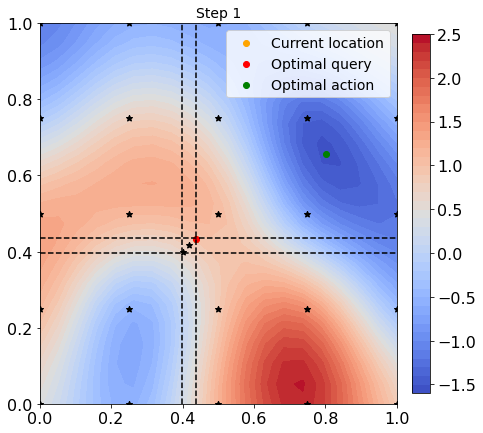

  1%|          | 1/100 [00:06<11:15,  6.82s/it]

x0:  [[0.44517239928245544, 0.43347495794296265]] , a:  [[0.5203481316566467, 0.5177912712097168]] , loss:  0.9655832003585666


 11%|█         | 11/100 [01:18<10:42,  7.22s/it]

x0:  [[0.4514995813369751, 0.44209685921669006]] , a:  [[0.6869145631790161, 0.6813834309577942]] , loss:  -1.217363493482539


 21%|██        | 21/100 [02:32<09:23,  7.13s/it]

x0:  [[0.4540572762489319, 0.44478607177734375]] , a:  [[0.7646556496620178, 0.7358149886131287]] , loss:  -1.466260749418104


 31%|███       | 31/100 [03:44<08:20,  7.25s/it]

x0:  [[0.454807311296463, 0.442764014005661]] , a:  [[0.7884739637374878, 0.7021617293357849]] , loss:  -1.5689502418819743


 41%|████      | 41/100 [04:58<07:03,  7.18s/it]

x0:  [[0.45508891344070435, 0.4394964575767517]] , a:  [[0.7965861558914185, 0.6441123485565186]] , loss:  -1.6075101974385209


 51%|█████     | 51/100 [06:09<05:50,  7.15s/it]

x0:  [[0.45526593923568726, 0.43966570496559143]] , a:  [[0.8012064695358276, 0.6454125642776489]] , loss:  -1.6163296377494616


 61%|██████    | 61/100 [07:24<04:57,  7.63s/it]

x0:  [[0.45537322759628296, 0.442095547914505]] , a:  [[0.8039641976356506, 0.6635151505470276]] , loss:  -1.6259261563178604


 71%|███████   | 71/100 [08:36<03:31,  7.30s/it]

x0:  [[0.45542171597480774, 0.44368135929107666]] , a:  [[0.8051393032073975, 0.656802237033844]] , loss:  -1.6289962147265724


 81%|████████  | 81/100 [09:48<02:15,  7.11s/it]

x0:  [[0.4554542899131775, 0.44492265582084656]] , a:  [[0.8060078024864197, 0.6520822048187256]] , loss:  -1.6302075059520453


 91%|█████████ | 91/100 [11:01<01:04,  7.18s/it]

x0:  [[0.4554818272590637, 0.44611212611198425]] , a:  [[0.8068729639053345, 0.6549504995346069]] , loss:  -1.6317617000311087


100%|██████████| 100/100 [12:07<00:00,  7.27s/it]


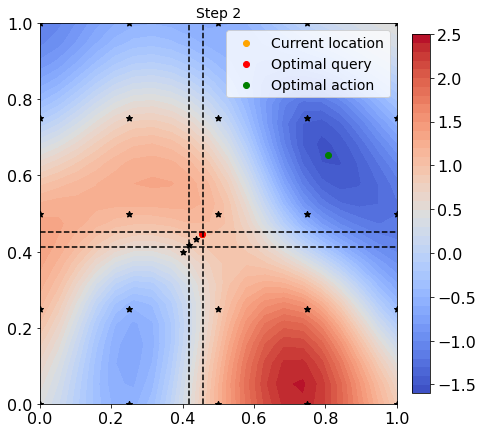

  1%|          | 1/100 [00:06<11:24,  6.92s/it]

x0:  [[0.4567839205265045, 0.45436975359916687]] , a:  [[0.5615133047103882, 0.5436357259750366]] , loss:  0.5738851141589123


 11%|█         | 11/100 [01:20<10:47,  7.28s/it]

x0:  [[0.46545007824897766, 0.46059465408325195]] , a:  [[0.7184926867485046, 0.6938658952713013]] , loss:  -1.4156913723848839


 21%|██        | 21/100 [02:32<09:24,  7.14s/it]

x0:  [[0.4695653021335602, 0.46220532059669495]] , a:  [[0.7837767601013184, 0.7279825806617737]] , loss:  -1.507563953156869


 31%|███       | 31/100 [03:45<08:32,  7.43s/it]

x0:  [[0.4710690975189209, 0.4610413610935211]] , a:  [[0.802821934223175, 0.6766050457954407]] , loss:  -1.6212532866437515


 41%|████      | 41/100 [04:57<07:14,  7.36s/it]

x0:  [[0.4716912806034088, 0.4601544141769409]] , a:  [[0.8094996809959412, 0.6296665668487549]] , loss:  -1.6210555192524545


 51%|█████     | 51/100 [06:08<05:46,  7.06s/it]

x0:  [[0.4720046818256378, 0.4612506628036499]] , a:  [[0.8135929703712463, 0.6480625867843628]] , loss:  -1.6357532787895874


 61%|██████    | 61/100 [07:21<04:40,  7.18s/it]

x0:  [[0.47220656275749207, 0.4617854654788971]] , a:  [[0.8149864673614502, 0.6577137112617493]] , loss:  -1.6352049437228635


 71%|███████   | 71/100 [08:35<03:31,  7.30s/it]

x0:  [[0.4723653197288513, 0.46163278818130493]] , a:  [[0.8145560026168823, 0.6461992859840393]] , loss:  -1.638233012722699


 81%|████████  | 81/100 [09:49<02:18,  7.30s/it]

x0:  [[0.4725205600261688, 0.461628794670105]] , a:  [[0.8142307996749878, 0.6461349129676819]] , loss:  -1.6393069433779832


 91%|█████████ | 91/100 [11:02<01:05,  7.23s/it]

x0:  [[0.47265779972076416, 0.46174898743629456]] , a:  [[0.8140021562576294, 0.6501061916351318]] , loss:  -1.6402056884298908


100%|██████████| 100/100 [12:09<00:00,  7.29s/it]


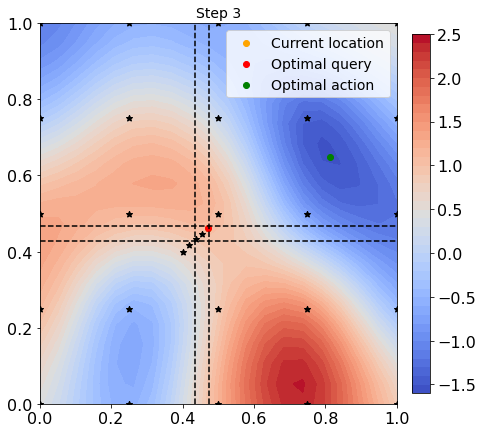

  1%|          | 1/100 [00:07<11:47,  7.15s/it]

x0:  [[0.4795982539653778, 0.46520450711250305]] , a:  [[0.5816854238510132, 0.5781871676445007]] , loss:  0.23420869989330326


 11%|█         | 11/100 [01:17<10:22,  6.99s/it]

x0:  [[0.48614054918289185, 0.4726352393627167]] , a:  [[0.7294125556945801, 0.7210211753845215]] , loss:  -1.436892731446482


 21%|██        | 21/100 [02:31<10:06,  7.68s/it]

x0:  [[0.488725483417511, 0.47397035360336304]] , a:  [[0.7916809916496277, 0.7256112098693848]] , loss:  -1.519379632476495


 31%|███       | 31/100 [03:43<08:15,  7.17s/it]

x0:  [[0.4894775450229645, 0.47230392694473267]] , a:  [[0.8104546666145325, 0.6567291617393494]] , loss:  -1.630988219023621


 41%|████      | 41/100 [04:56<07:11,  7.32s/it]

x0:  [[0.48978275060653687, 0.47190195322036743]] , a:  [[0.8182832598686218, 0.6252152323722839]] , loss:  -1.6209927840046017


 51%|█████     | 51/100 [06:09<05:53,  7.22s/it]

x0:  [[0.4899955093860626, 0.4731830954551697]] , a:  [[0.822908878326416, 0.6505327820777893]] , loss:  -1.633299188366925


 61%|██████    | 61/100 [07:20<04:39,  7.16s/it]

x0:  [[0.48991796374320984, 0.4737977981567383]] , a:  [[0.8226568698883057, 0.6508525609970093]] , loss:  -1.6344380871486344


 71%|███████   | 71/100 [08:33<03:31,  7.30s/it]

x0:  [[0.48967111110687256, 0.4742581844329834]] , a:  [[0.8204927444458008, 0.6408990621566772]] , loss:  -1.636348219648072


 81%|████████  | 81/100 [09:46<02:17,  7.24s/it]

x0:  [[0.48934876918792725, 0.4752279222011566]] , a:  [[0.8190404772758484, 0.6463243961334229]] , loss:  -1.638558283542291


 91%|█████████ | 91/100 [11:00<01:08,  7.60s/it]

x0:  [[0.48864126205444336, 0.4764096438884735]] , a:  [[0.8173785209655762, 0.6483734846115112]] , loss:  -1.6413616041336943


100%|██████████| 100/100 [12:05<00:00,  7.25s/it]


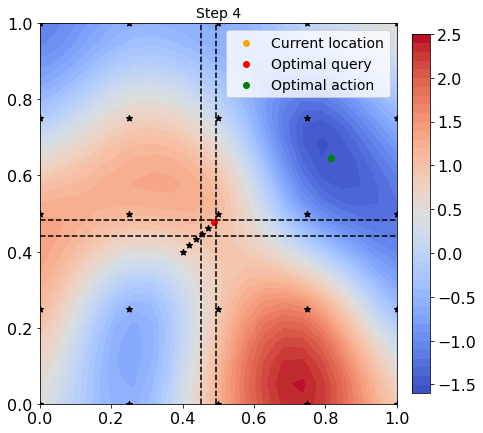

  1%|          | 1/100 [00:06<11:19,  6.86s/it]

x0:  [[0.4892193078994751, 0.4785395860671997]] , a:  [[0.5774879455566406, 0.5522216558456421]] , loss:  0.4288277549727543


 11%|█         | 11/100 [01:21<10:57,  7.39s/it]

x0:  [[0.49171870946884155, 0.47743138670921326]] , a:  [[0.7244964241981506, 0.7052604556083679]] , loss:  -1.4282603605057587


 21%|██        | 21/100 [02:36<09:47,  7.44s/it]

x0:  [[0.4930804371833801, 0.4768811762332916]] , a:  [[0.7863826751708984, 0.7297075986862183]] , loss:  -1.4967231398944068


 31%|███       | 31/100 [03:48<08:10,  7.12s/it]

x0:  [[0.49368539452552795, 0.47600483894348145]] , a:  [[0.8047459721565247, 0.671427845954895]] , loss:  -1.6106870697435671


 41%|████      | 41/100 [05:02<07:16,  7.40s/it]

x0:  [[0.4940205514431, 0.4754403233528137]] , a:  [[0.8121464252471924, 0.6312941908836365]] , loss:  -1.6051487769976653


 51%|█████     | 51/100 [06:17<06:05,  7.46s/it]

x0:  [[0.49427804350852966, 0.4752979874610901]] , a:  [[0.8175241947174072, 0.6514068841934204]] , loss:  -1.6201008662940444


 61%|██████    | 61/100 [07:31<04:47,  7.36s/it]

x0:  [[0.49441856145858765, 0.4751713275909424]] , a:  [[0.8192223310470581, 0.6578567624092102]] , loss:  -1.6207378286811789


 71%|███████   | 71/100 [08:44<03:33,  7.35s/it]

x0:  [[0.49447935819625854, 0.4750033915042877]] , a:  [[0.8184436559677124, 0.64637690782547]] , loss:  -1.6243532936056198


 81%|████████  | 81/100 [09:57<02:25,  7.64s/it]

x0:  [[0.4945400655269623, 0.4749268889427185]] , a:  [[0.8178824782371521, 0.6472932696342468]] , loss:  -1.626386255712496


 91%|█████████ | 91/100 [11:11<01:05,  7.33s/it]

x0:  [[0.494598925113678, 0.4748785197734833]] , a:  [[0.8173586130142212, 0.650855302810669]] , loss:  -1.6280966197847773


100%|██████████| 100/100 [12:17<00:00,  7.37s/it]


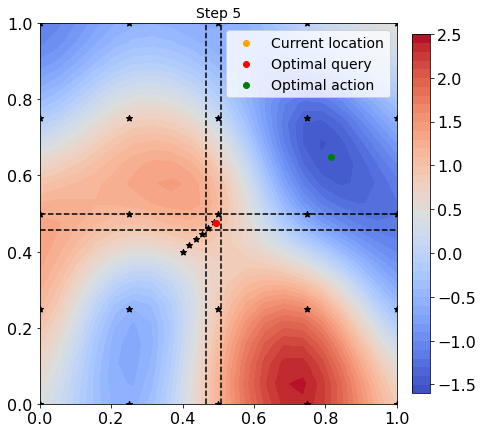

  1%|          | 1/100 [00:07<11:40,  7.08s/it]

x0:  [[0.4991949796676636, 0.4766610264778137]] , a:  [[0.6051766276359558, 0.5622251033782959]] , loss:  0.12671014287415783


 11%|█         | 11/100 [01:21<10:50,  7.31s/it]

x0:  [[0.5068737864494324, 0.4846852421760559]] , a:  [[0.7573246955871582, 0.7148204445838928]] , loss:  -1.5046180756672634


 21%|██        | 21/100 [02:34<09:30,  7.23s/it]

x0:  [[0.5097240209579468, 0.48451200127601624]] , a:  [[0.8113502264022827, 0.7119076251983643]] , loss:  -1.5339077174391476


 31%|███       | 31/100 [03:48<08:28,  7.36s/it]

x0:  [[0.5102139711380005, 0.48068276047706604]] , a:  [[0.8216346502304077, 0.639315664768219]] , loss:  -1.6058945361486836


 41%|████      | 41/100 [05:01<07:01,  7.15s/it]

x0:  [[0.5103428363800049, 0.4815784990787506]] , a:  [[0.8232812285423279, 0.6298548579216003]] , loss:  -1.6011483806597766


 51%|█████     | 51/100 [06:15<06:06,  7.48s/it]

x0:  [[0.5103611946105957, 0.4846259355545044]] , a:  [[0.8218801617622375, 0.6578502655029297]] , loss:  -1.6099419676591555


 61%|██████    | 61/100 [07:29<04:52,  7.49s/it]

x0:  [[0.5101325511932373, 0.48561760783195496]] , a:  [[0.8160622715950012, 0.6513739228248596]] , loss:  -1.6160156375706995


 71%|███████   | 71/100 [08:47<03:44,  7.73s/it]

x0:  [[0.5100449323654175, 0.4863111972808838]] , a:  [[0.8115614056587219, 0.6476971507072449]] , loss:  -1.6171288183551242


 81%|████████  | 81/100 [10:00<02:17,  7.24s/it]

x0:  [[0.5102114081382751, 0.4870924949645996]] , a:  [[0.810361385345459, 0.6551089882850647]] , loss:  -1.6184020253552094


 91%|█████████ | 91/100 [11:16<01:11,  7.90s/it]

x0:  [[0.5104360580444336, 0.487478107213974]] , a:  [[0.8098897933959961, 0.6530344486236572]] , loss:  -1.6193356096968758


100%|██████████| 100/100 [12:23<00:00,  7.43s/it]


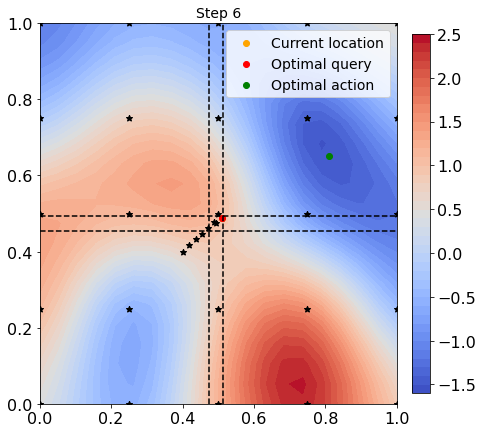

  1%|          | 1/100 [00:07<12:57,  7.85s/it]

x0:  [[0.5163666605949402, 0.4927403926849365]] , a:  [[0.6204439401626587, 0.5947908163070679]] , loss:  -0.1490982277405214


 11%|█         | 11/100 [01:22<11:08,  7.51s/it]

x0:  [[0.5235444903373718, 0.4996298551559448]] , a:  [[0.7677354216575623, 0.7347046732902527]] , loss:  -1.4716318330158886


 21%|██        | 21/100 [02:36<09:39,  7.33s/it]

x0:  [[0.5258722901344299, 0.49870675802230835]] , a:  [[0.816940426826477, 0.6997416615486145]] , loss:  -1.5545608294830071


 31%|███       | 31/100 [03:49<08:25,  7.32s/it]

x0:  [[0.526172399520874, 0.496364027261734]] , a:  [[0.8257448077201843, 0.6195083856582642]] , loss:  -1.5959254624379344


 41%|████      | 41/100 [05:07<07:28,  7.61s/it]

x0:  [[0.526374340057373, 0.49787092208862305]] , a:  [[0.8287392854690552, 0.6356898546218872]] , loss:  -1.6107121558588064


 51%|█████     | 51/100 [06:20<05:57,  7.29s/it]

x0:  [[0.5263729691505432, 0.4991510510444641]] , a:  [[0.8248304128646851, 0.6555624604225159]] , loss:  -1.6132210370812494


 61%|██████    | 61/100 [07:35<04:47,  7.37s/it]

x0:  [[0.5262086987495422, 0.49909070134162903]] , a:  [[0.8157640099525452, 0.6434898972511292]] , loss:  -1.6199443132929467


 71%|███████   | 71/100 [08:49<03:35,  7.44s/it]

x0:  [[0.5263891220092773, 0.49931710958480835]] , a:  [[0.8111852407455444, 0.6509050726890564]] , loss:  -1.6222864300691089


 81%|████████  | 81/100 [10:05<02:23,  7.58s/it]

x0:  [[0.5267517566680908, 0.4992174208164215]] , a:  [[0.809657096862793, 0.6547736525535583]] , loss:  -1.623214915579144


 91%|█████████ | 91/100 [11:20<01:07,  7.55s/it]

x0:  [[0.5271466374397278, 0.49877697229385376]] , a:  [[0.8094878196716309, 0.6507166624069214]] , loss:  -1.624276449296268


100%|██████████| 100/100 [12:30<00:00,  7.51s/it]


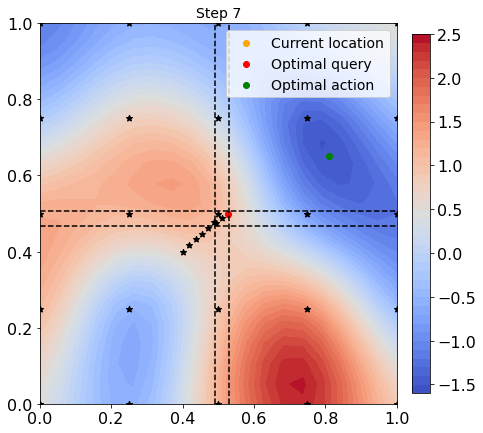

  1%|          | 1/100 [00:07<12:20,  7.48s/it]

x0:  [[0.5289868712425232, 0.5051757097244263]] , a:  [[0.6285507678985596, 0.6120243072509766]] , loss:  -0.27259612341484757


 11%|█         | 11/100 [01:25<11:28,  7.74s/it]

x0:  [[0.5369340181350708, 0.5107662677764893]] , a:  [[0.7778522968292236, 0.7386409640312195]] , loss:  -1.4716913450226299


 21%|██        | 21/100 [02:44<10:17,  7.81s/it]

x0:  [[0.5394281148910522, 0.5071276426315308]] , a:  [[0.8226097822189331, 0.6830794811248779]] , loss:  -1.5807485366303782


 31%|███       | 31/100 [03:59<08:46,  7.63s/it]

x0:  [[0.5392405986785889, 0.5063143968582153]] , a:  [[0.8288272619247437, 0.6127027273178101]] , loss:  -1.5942865032296931


 41%|████      | 41/100 [05:18<07:52,  8.01s/it]

x0:  [[0.5393980741500854, 0.5089202523231506]] , a:  [[0.8305227160453796, 0.6413336396217346]] , loss:  -1.61503366546603


 51%|█████     | 51/100 [06:39<06:30,  7.97s/it]

x0:  [[0.5395312905311584, 0.508672833442688]] , a:  [[0.8240158557891846, 0.6517513990402222]] , loss:  -1.6199466408742544


 61%|██████    | 61/100 [07:55<05:01,  7.73s/it]

x0:  [[0.5397577881813049, 0.5063223242759705]] , a:  [[0.8145191669464111, 0.6415456533432007]] , loss:  -1.6253763530495864


 71%|███████   | 71/100 [09:13<03:46,  7.82s/it]

x0:  [[0.540382444858551, 0.5047391653060913]] , a:  [[0.810916006565094, 0.6519609093666077]] , loss:  -1.628258770170531


 81%|████████  | 81/100 [10:34<02:36,  8.25s/it]

x0:  [[0.5408873558044434, 0.5040228366851807]] , a:  [[0.8085892796516418, 0.6525599956512451]] , loss:  -1.6290207294943342


 91%|█████████ | 91/100 [11:51<01:07,  7.55s/it]

x0:  [[0.5413540005683899, 0.504557192325592]] , a:  [[0.8080819845199585, 0.6510029435157776]] , loss:  -1.6297765585191948


100%|██████████| 100/100 [13:03<00:00,  7.84s/it]


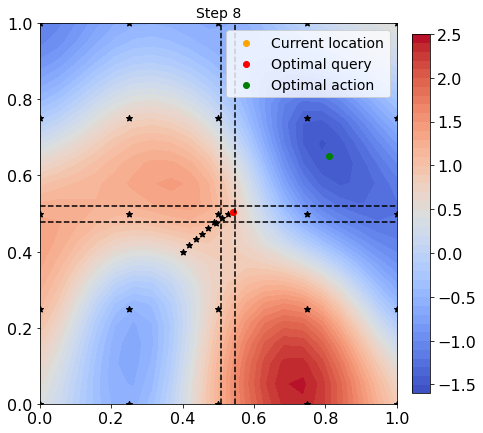

  1%|          | 1/100 [00:07<12:32,  7.61s/it]

x0:  [[0.5441624522209167, 0.5113507509231567]] , a:  [[0.6220775246620178, 0.6227918267250061]] , loss:  -0.2361658073748094


 11%|█         | 11/100 [01:23<11:15,  7.59s/it]

x0:  [[0.5519900918006897, 0.5164990425109863]] , a:  [[0.7781105041503906, 0.7432080507278442]] , loss:  -1.453297722305089


 21%|██        | 21/100 [02:38<10:13,  7.76s/it]

x0:  [[0.5543937683105469, 0.5106488466262817]] , a:  [[0.8247641921043396, 0.6752539277076721]] , loss:  -1.5989926201603215


 31%|███       | 31/100 [03:54<08:44,  7.61s/it]

x0:  [[0.554637610912323, 0.5091335773468018]] , a:  [[0.829978883266449, 0.607919454574585]] , loss:  -1.597017284154841


 41%|████      | 41/100 [05:17<08:39,  8.81s/it]

x0:  [[0.5549207329750061, 0.5138575434684753]] , a:  [[0.829583466053009, 0.6447551846504211]] , loss:  -1.6220545373997577


 51%|█████     | 51/100 [06:34<06:10,  7.56s/it]

x0:  [[0.5553252100944519, 0.512368381023407]] , a:  [[0.8206483721733093, 0.6490057706832886]] , loss:  -1.6300534716694195


 61%|██████    | 61/100 [07:55<05:33,  8.56s/it]

x0:  [[0.5557379126548767, 0.5092311501502991]] , a:  [[0.810738205909729, 0.6421041488647461]] , loss:  -1.6338988844150018


 71%|███████   | 71/100 [09:12<03:46,  7.81s/it]

x0:  [[0.5561345219612122, 0.5100298523902893]] , a:  [[0.8070920705795288, 0.6546284556388855]] , loss:  -1.6357461818701748


 81%|████████  | 81/100 [10:30<02:31,  7.99s/it]

x0:  [[0.5565354228019714, 0.5098443627357483]] , a:  [[0.8061224818229675, 0.6511440873146057]] , loss:  -1.636674115150023


 91%|█████████ | 91/100 [11:43<01:05,  7.23s/it]

x0:  [[0.5569595098495483, 0.51005619764328]] , a:  [[0.8079352974891663, 0.6500232815742493]] , loss:  -1.637417226363375


100%|██████████| 100/100 [12:49<00:00,  7.70s/it]


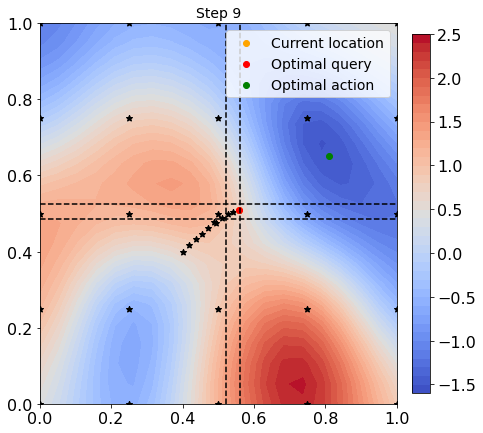

In [8]:
# @title 2D

save = True
n_dim = 2
dim_xi = [1, n_dim]
prev_x = torch.tensor([[0.4, 0.4]])
neighbor_size = 0.02
budget = 10

horizon = 20
ehig_opt_epoch = 100
ehig_opt_lr = 0.1
use_lr_schedule = False
train = False

train_x, train_y = init_data(n_init=5)

model = init_model(
    n_dim=n_dim, prev_x=prev_x, train_x=train_x, train_y=train_y, train=train
)

for step in range(budget):
    best_result = argmax_ehig(
        model,
        prev_x,
        horizon=horizon,
        ehig_opt_epoch=ehig_opt_epoch,
        ehig_opt_lr=ehig_opt_lr,
        neighbor_size=neighbor_size,
        use_lr_schedule=use_lr_schedule,
    )

    next_x = best_result[0]
    next_y = func(next_x.reshape(-1, n_dim))

    # update data and model
    train_x = torch.cat([train_x, next_x.reshape(-1, n_dim)])
    train_y = torch.cat([train_y, next_y])

    model = init_model(
        n_dim=n_dim, prev_x=prev_x, train_x=train_x, train_y=train_y, train=train
    )

    plt.title(f"Step {step}")

    draw_posterior(n_dim=n_dim, model=model)

    plt.hlines(prev_x[0, 1] - neighbor_size, 0, 1, linestyle="--")
    plt.hlines(prev_x[0, 1] + neighbor_size, 0, 1, linestyle="--")

    plt.vlines(prev_x[0, 0] - neighbor_size, 0, 1, linestyle="--")
    plt.vlines(prev_x[0, 0] + neighbor_size, 0, 1, linestyle="--")
    prev_x = next_x

    plt.scatter(train_x[:, 0], train_x[:, 1], marker="*", color="black")
    plt.scatter(prev_x[0, 0], prev_x[0, 1], color="orange", label="Current location")
    plt.scatter(
        best_result[0][0, 0], best_result[0][0, 1], color="red", label="Optimal query"
    )
    plt.scatter(
        best_result[-1][0, 0],
        best_result[-1][0, 1],
        color="green",
        label="Optimal action",
    )

    plt.legend()

    if save:
        plt.savefig(f"{path}/2D/step{step}.{imgtype}", dpi=dpi, bbox_inches="tight")

    plt.show()